网址：
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/submissions

In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [4]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv下载../data/kaggle_house_pred_train.csv...
正在从http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv下载../data/kaggle_house_pred_test.csv...


In [6]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [10]:
print(train_data.iloc[0:2, [0, 1, 2,-3, -2, -1]])
print(test_data.iloc[0:2, [0, 1, 2, -3,-2, -1]])

   Id  MSSubClass MSZoning SaleType SaleCondition  SalePrice
0   1          60       RL       WD        Normal     208500
1   2          20       RL       WD        Normal     181500
     Id  MSSubClass MSZoning  YrSold SaleType SaleCondition
0  1461          20       RH    2010       WD        Normal
1  1462          20       RL    2010       WD        Normal


In [35]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [36]:
#numeric_features选择了所有数值型的列（例如int、float等类型）index属性返回这些选定列的名称。
numeric_features = all_features.dtypes[all_features.dtypes!= 'object'].index
# 数据标准化
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 补全缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [37]:
print(all_features.shape)
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True,dtype=int) # dtype指定处理类型为数值型，如int
print(all_features.shape)

(2919, 79)
(2919, 330)


In [38]:
# 从pandas格式中提取Numpy格式，并将其转换为张量表示
print(train_data.shape)
n_train = train_data.shape[0] # 样本个数
train_features = torch.tensor(all_features[:n_train].values,
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values,
                             dtype=torch.float32)
# train_data的SalePrice列是label值
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1),
                            dtype=torch.float32)

(1460, 81)


以上注意：
- .values 操作是提取数据中的实际数值内容（如果 all_features 是 pandas 的 DataFrame 等结构，通过这个操作能获取到其内部的 numpy 数组形式的数值），然后使用 torch.tensor() 函数将这些数值转换为 PyTorch 中的张量（tensor）类型，便于后续在深度学习模型中进行处理
- type=torch.float32，明确了该张量的数据类型为单精度浮点数类型

In [45]:
# 训练
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。
因此，[**我们更关心相对误差$\frac{y - \hat{y}}{y}$，**]
而不是绝对误差$y - \hat{y}$。


(**解决这个问题的一种方法是用价格预测的对数来衡量差异**)。
事实上，这也是比赛中官方用来评价提交质量的误差指标。
即将$\delta$ for $|\log y - \log \hat{y}| \leq \delta$
转换为$e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$。
这使得预测价格的对数与真实标签价格的对数之间出现以下均方根误差：

$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$


In [47]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()  # .item()用于在只包含一个元素的tensor中提取值，注意是只包含一个元素，

In [51]:
# 训练
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []  # 用于存储训练过程中的模型性能评估指标
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optim = torch.optim.Adam(net.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optim.zero_grad()
            l=loss(net(X),y)
            l.backward()
            optim.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [52]:
# K折交叉验证
def get_k_fold_data(k,i,X,y): # 给定k折，给定第i折，返回相应的训练集、测试集
    assert k > 1
    fold_size = X.shape[0] // k  # 每一折的大小为样本数除以k
    X_train, y_train = None, None
    for j in range(k): # 每一折
        idx = slice(j * fold_size, (j+1)*fold_size) # 每一折的切片索引间隔  
        X_part, y_part = X[idx,:], y[idx] # 把每一折对应部分取出来
        if j == i: # i表示第几折，把它作为验证集
            X_valid, y_valid = X_part, y_part
        elif X_train is None: # 第一次看到X_train，则把它存起来 
            X_train, y_train = X_part, y_part
        else: # 后面再看到，除了第i外，其余折也作为训练数据集，用torch.cat将原先的合并    
            X_train = torch.cat([X_train, X_part],0)
            y_train = torch.cat([y_train, y_part],0)
    return X_train, y_train, X_valid, y_valid # 返回训练集和验证集

# 返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train) # 把第i折对应分开的数据集、验证集拿出来   
        net = get_net()
        # *是解码，变成前面返回的四个数据
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size) # 训练集、验证集丢进train函数 
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls,valid_ls],
                    xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],
                    legend=['train','valid'],yscale='log')
        print(f'fold{i+1},train log rmse {float(train_ls[-1]):f},'
             f'valid log rmse {float (valid_ls[-1]):f}')
    return  train_l_sum / k, valid_l_sum / k # 求和做平均

fold1,train log rmse 0.130584,valid log rmse 0.146851
fold2,train log rmse 0.133003,valid log rmse 0.129822
fold3,train log rmse 0.128410,valid log rmse 0.148790
fold4,train log rmse 0.126507,valid log rmse 0.151319
fold5,train log rmse 0.134455,valid log rmse 0.118677
fold6,train log rmse 0.131229,valid log rmse 0.154820
fold7,train log rmse 0.128291,valid log rmse 0.170051
7-折验证：平均训练log rmse：0.130354,平均验证log rmse：0.145761


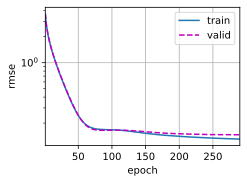

In [62]:
# 模型选择
k, num_epochs, lr, weight_decay, batch_size = 7, 290, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)   
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'f'平均验证log rmse：{float(valid_l):f}')    

RMSE（Root Mean Square Error）：均方根误差
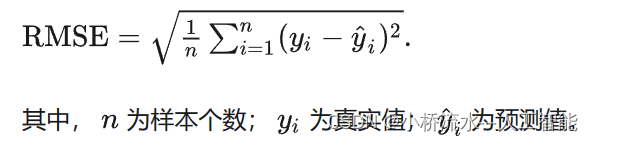

 提交kaggle预测


In [63]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.128470


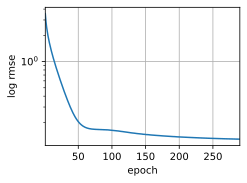

In [64]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)